In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json, joblib

from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler

import shap

df = pd.read_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\nfhs4_features_ready.csv")
scaler = joblib.load("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\feature_scaler.pkl")

with open("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\selected_features.json") as f:
    Selected_features = json.load(f)

TARGET = "stunting"

# Raw features (for RF + SHAP)
X = df[Selected_features].values
y = df[TARGET].values

# Scaled features (for linear models)
X_sc = df[[f"{c}_sc" for c in Selected_features]].values

# Train/test split — same seed throughout
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_sc_train, X_sc_test = train_test_split(X_sc, test_size=0.2, random_state=42)

print(f" Loaded  : {df.shape}")
print(f" Train  : {X_train.shape[0]} districts")
print(f" Test   : {X_test.shape[0]} districts")
print(f" Features: {len(Selected_features)}")

 Loaded  : (607, 35)
 Train  : 485 districts
 Test   : 122 districts
 Features: 15


In [11]:
# Define a function to train, evaluate, and return results for a given model
def evaluate(name, model, X_tr, X_te, y_tr, y_te, cv=5):
    """Train, evaluate, and return a results dict."""
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_te)
    r2 = r2_score(y_te, y_pred)
    rmse = np.sqrt(mean_squared_error(y_te, y_pred))
    mae = mean_absolute_error(y_te, y_pred)
    cv_r2 = cross_val_score(model, X_tr, y_tr, cv=KFold(cv, shuffle=True, random_state=42), scoring="r2")
    results = {
        "Model"      : name,
        "R²"         : round(r2,   3),
        "RMSE"       : round(rmse, 3),
        "MAE"        : round(mae,  3),
        "CV R² Mean" : round(cv_r2.mean(), 3),
        "CV R² Std"  : round(cv_r2.std(),  3),
    }
    print(f"  {name}:")
    print(f"  R²           : {r2:.4f}")
    print(f"  RMSE         : {rmse:.4f}  (in % stunting units)")
    print(f"  MAE          : {mae:.4f}")
    print(f"  CV R² (5-fold): {cv_r2.mean():.4f} ± {cv_r2.std():.4f}")

    return results, model, y_pred

all_results = []

In [12]:
# Using SCALED features for linear models
res_lr, mdl_lr, pred_lr = evaluate("Linear Regression (OLS)", LinearRegression(), X_sc_train, X_sc_test, y_train, y_test)
all_results.append(res_lr)

  Linear Regression (OLS):
  R²           : 0.6710
  RMSE         : 5.9907  (in % stunting units)
  MAE          : 4.8425
  CV R² (5-fold): 0.5608 ± 0.0446


In [13]:
# RidgeCV automatically selects best alpha from the candidates
ridge_cv = RidgeCV(alphas=np.logspace(-2, 4, 100), cv=5, scoring="r2")
res_ridge, mdl_ridge, pred_ridge = evaluate("Ridge Regression", ridge_cv, X_sc_train, X_sc_test, y_train, y_test)
all_results.append(res_ridge)
print(f"\n  Best alpha (λ) selected by CV: {mdl_ridge.alpha_:.4f}")

  Ridge Regression:
  R²           : 0.6724
  RMSE         : 5.9775  (in % stunting units)
  MAE          : 4.8373
  CV R² (5-fold): 0.5672 ± 0.0487

  Best alpha (λ) selected by CV: 49.7702


In [14]:
# Lasso performs automatic feature selection (drives weak coefficients to 0)
lasso_cv = LassoCV(alphas=np.logspace(-3, 2, 100), cv=5, random_state=42, max_iter=10000)
res_lasso, mdl_lasso, pred_lasso = evaluate("Lasso Regression", lasso_cv, X_sc_train, X_sc_test, y_train, y_test)
all_results.append(res_lasso)
print(f"\n  Best alpha (λ) selected by CV: {mdl_lasso.alpha_:.6f}")

# Which features did Lasso zero out?
lasso_coefs = pd.DataFrame({"Feature"    : Selected_features, "Coefficient": mdl_lasso.coef_}).sort_values("Coefficient", key=abs, ascending=False)

print(f"\n  Features zeroed out by Lasso: " f"{(lasso_coefs['Coefficient'] == 0).sum()}")
print(lasso_coefs.to_string(index=False))

  Lasso Regression:
  R²           : 0.6741
  RMSE         : 5.9626  (in % stunting units)
  MAE          : 4.8524
  CV R² (5-fold): 0.5712 ± 0.0476

  Best alpha (λ) selected by CV: 0.187382

  Features zeroed out by Lasso: 4
              Feature  Coefficient
         wealth_proxy    -2.201124
nutrition_deprivation     2.037985
       fertility_risk     1.757833
    empowerment_score    -1.718146
    oop_delivery_cost    -0.978484
   birth_registration    -0.798551
      excl_breastfeed    -0.653715
     unmet_need_total     0.370751
     healthcare_score    -0.346245
   immunization_score    -0.052188
       diarrhoea_prev     0.034131
           wash_score    -0.000000
            vitamin_a    -0.000000
          ifa_100days     0.000000
     early_breastfeed    -0.000000


In [15]:
# Uses RAW (unscaled) features — tree models don't need scaling
rf = RandomForestRegressor(n_estimators=300, max_depth=None, min_samples_leaf=5, random_state=42, n_jobs=-1)
res_rf, mdl_rf, pred_rf = evaluate("Random Forest", rf, X_train, X_test, y_train, y_test)   
all_results.append(res_rf)

  Random Forest:
  R²           : 0.6960
  RMSE         : 5.7585  (in % stunting units)
  MAE          : 4.6910
  CV R² (5-fold): 0.6108 ± 0.0604


  MODEL COMPARISON SUMMARY:
                  Model    R²  RMSE   MAE  CV R² Mean  CV R² Std
          Random Forest 0.696 5.759 4.691       0.611      0.060
       Lasso Regression 0.674 5.963 4.852       0.571      0.048
       Ridge Regression 0.672 5.978 4.837       0.567      0.049
Linear Regression (OLS) 0.671 5.991 4.843       0.561      0.045


C:\Users\Fredrik\AppData\Local\Temp\ipykernel_14728\3844570343.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15, ha="right", fontsize=9)
C:\Users\Fredrik\AppData\Local\Temp\ipykernel_14728\3844570343.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15, ha="right", fontsize=9)
C:\Users\Fredrik\AppData\Local\Temp\ipykernel_14728\3844570343.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(models, rotation=15, ha="right", fontsize=9)


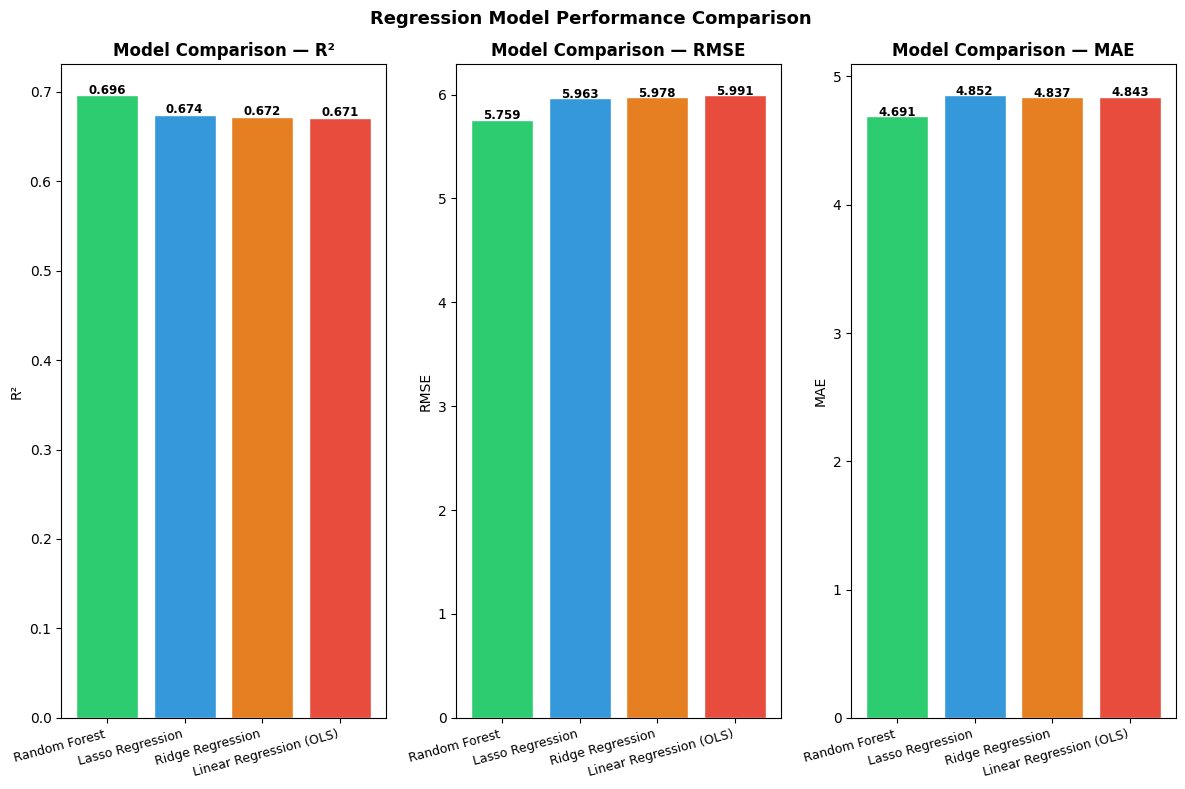

In [16]:
# Compile results into a DataFrame for comparison and visualization
results_df = pd.DataFrame(all_results).sort_values("R²", ascending=False)

print("  MODEL COMPARISON SUMMARY:")
print(results_df.to_string(index=False))

fig, axes = plt.subplots(1, 3, figsize=(12, 8))
models    = results_df["Model"]
palette   = ["#2ECC71", "#3498DB", "#E67E22", "#E74C3C"][:len(models)]

for ax, metric in zip(axes, ["R²", "RMSE", "MAE"]):
    vals   = results_df[metric]
    bars   = ax.bar(models, vals, color=palette, edgecolor="white")
    ax.set_title(f"Model Comparison — {metric}", fontweight="bold")
    ax.set_ylabel(metric)
    ax.set_xticklabels(models, rotation=15, ha="right", fontsize=9)
    for bar, v in zip(bars, vals):
        ax.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.002, f"{v:.3f}", ha="center", fontsize=8.5, fontweight="bold")

plt.suptitle("Regression Model Performance Comparison", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\10_model_comparison.png", dpi=150, bbox_inches="tight")
plt.show()

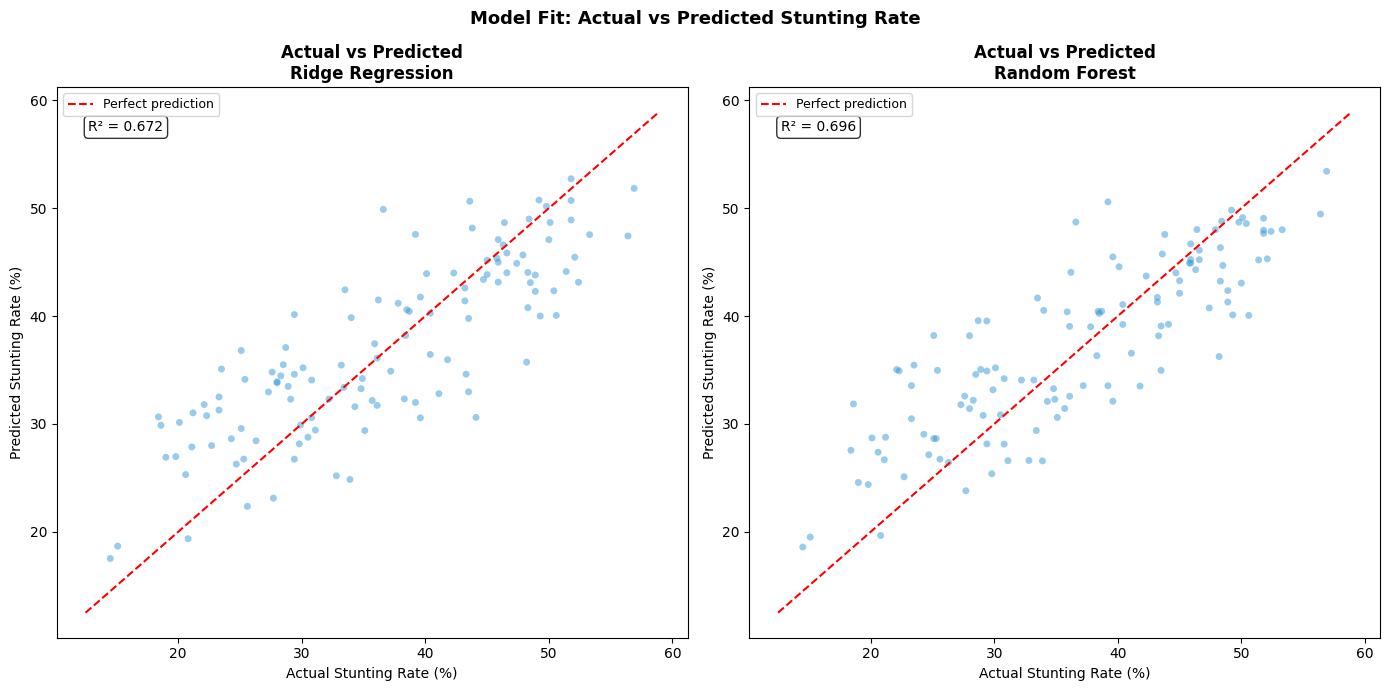

In [17]:
# Visualize actual vs predicted stunting rates for the two best models
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

for ax, (name, preds) in zip(axes, [("Ridge Regression", pred_ridge), ("Random Forest",    pred_rf)]):
    ax.scatter(y_test, preds, alpha=0.5, s=25, color="#3498DB", edgecolors="none")
    lims = [min(y_test.min(), preds.min()) - 2, max(y_test.max(), preds.max()) + 2]
    ax.plot(lims, lims, "r--", linewidth=1.5, label="Perfect prediction")
    ax.set_xlabel("Actual Stunting Rate (%)")
    ax.set_ylabel("Predicted Stunting Rate (%)")
    ax.set_title(f"Actual vs Predicted\n{name}", fontweight="bold")
    r2 = r2_score(y_test, preds)
    ax.text(0.05, 0.92, f"R² = {r2:.3f}", transform=ax.transAxes, fontsize=10, bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))
    ax.legend(fontsize=9)

plt.suptitle("Model Fit: Actual vs Predicted Stunting Rate", fontsize=13, fontweight="bold")
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\11_actual_vs_predicted.png", dpi=150, bbox_inches="tight")
plt.show()

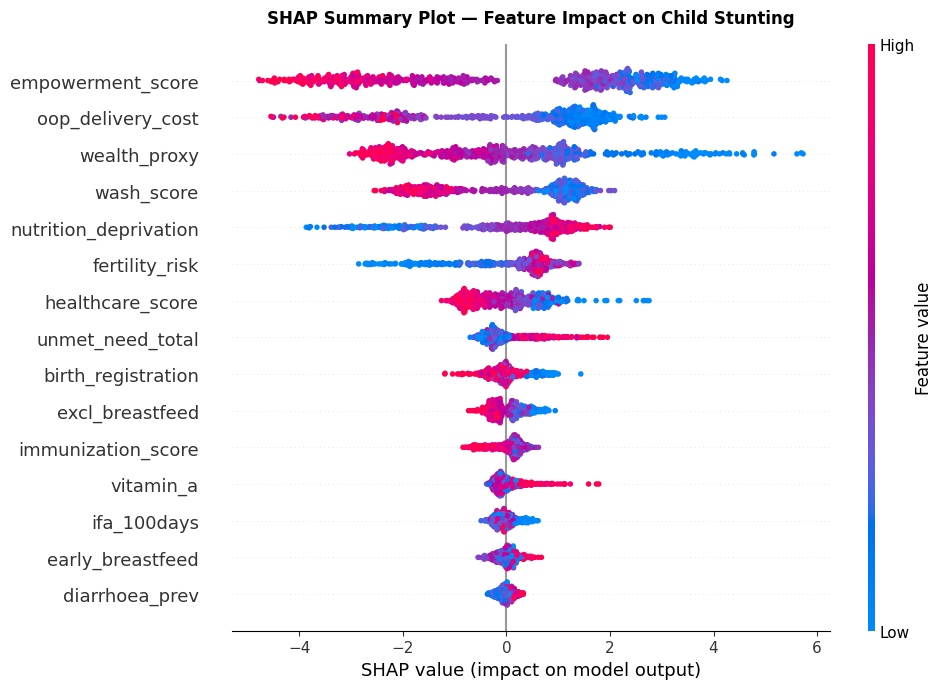

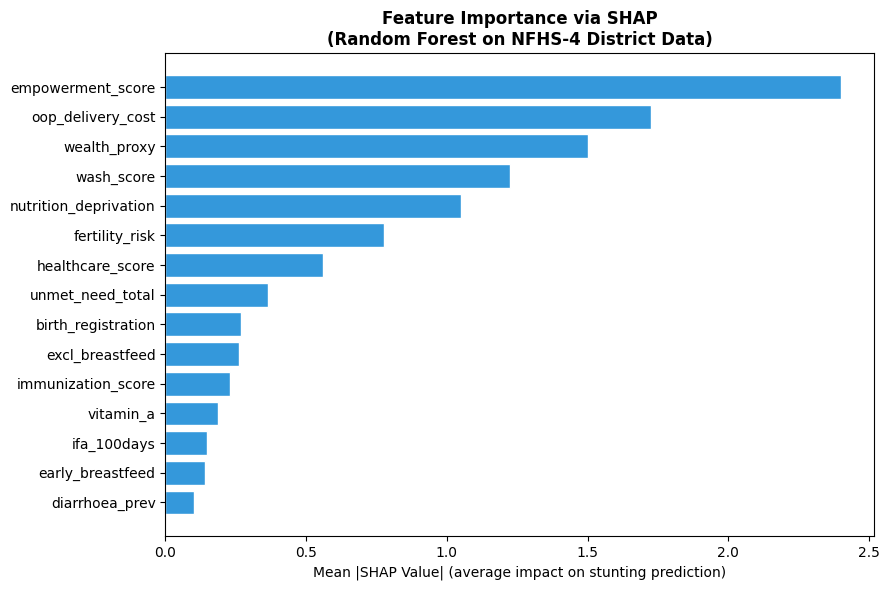


 SHAP Feature Importance (sorted) 
              Feature  Mean |SHAP|
    empowerment_score     2.399325
    oop_delivery_cost     1.724910
         wealth_proxy     1.501541
           wash_score     1.224213
nutrition_deprivation     1.049062
       fertility_risk     0.775831
     healthcare_score     0.561445
     unmet_need_total     0.364648
   birth_registration     0.267862
      excl_breastfeed     0.261419
   immunization_score     0.230573
            vitamin_a     0.187200
          ifa_100days     0.146462
     early_breastfeed     0.141156
       diarrhoea_prev     0.100586


In [18]:
# SHAP values for Random Forest to interpret feature importance and impact on predictions
explainer   = shap.TreeExplainer(mdl_rf)
shap_values = explainer.shap_values(X)    # full dataset for richer SHAP

shap_df = pd.DataFrame(shap_values, columns=Selected_features)

#  SHAP Summary 
plt.figure(figsize=(10, 7))
shap.summary_plot(shap_values, X, feature_names=Selected_features, show=False, plot_size=(10, 7))
plt.title("SHAP Summary Plot — Feature Impact on Child Stunting", fontsize=12, fontweight="bold", pad=15)
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\12_shap_summary.png", dpi=150, bbox_inches="tight")
plt.show()

# SHAP Mean Absolute Importance Bar 
mean_shap = pd.DataFrame({"Feature" : Selected_features, "Mean |SHAP|" : np.abs(shap_values).mean(axis=0)}).sort_values("Mean |SHAP|", ascending=True)

fig, ax = plt.subplots(figsize=(9, 6))
ax.barh(mean_shap["Feature"], mean_shap["Mean |SHAP|"], color="#3498DB", edgecolor="white")
ax.set_xlabel("Mean |SHAP Value| (average impact on stunting prediction)")
ax.set_title("Feature Importance via SHAP\n(Random Forest on NFHS-4 District Data)", fontweight="bold")
plt.tight_layout()
plt.savefig("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\figures\\13_shap_importance.png", dpi=150, bbox_inches="tight")
plt.show()

print("\n SHAP Feature Importance (sorted) ")
print(mean_shap.sort_values("Mean |SHAP|", ascending=False).to_string(index=False))

In [19]:
# Add predictions from best model back to full dataframe
df["predicted_stunting_rf"] = mdl_rf.predict(X)
df["predicted_stunting_ridge"] = mdl_ridge.predict(X_sc)
df["residual_rf"] = df[TARGET] - df["predicted_stunting_rf"]

# Save model
joblib.dump(mdl_rf, "C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\models\\rf_model.pkl")
joblib.dump(mdl_ridge, "C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Outputs\\models\\ridge_model.pkl")

# Save predictions
df.to_csv("C:\\Users\\Fredrik\\vscode_projects\\Projects\\NFHS_Project\\Data\\processed\\nfhs4_with_predictions.csv", index=False)

print(f"\n Largest Residuals ")
print(df[["state", "district", TARGET, "predicted_stunting_rf", "residual_rf"]].reindex(df["residual_rf"].abs().sort_values(ascending=False).index).head(10).to_string(index=False))


 Largest Residuals 
state         district  stunting  predicted_stunting_rf  residual_rf
   KA           Mandya      18.6              31.852259   -13.252259
   UT        Bageshwar      25.1              38.192390   -13.092390
   AP           Guntur      22.1              35.032946   -12.932946
   HR          Jhajjar      22.3              34.920427   -12.620427
   ML East Khasi Hills      48.5              36.308515    12.191485
   RJ           Barmer      36.6              48.713338   -12.113338
   GJ            Anand      48.2              36.243694    11.956306
   HR     Mahendragarh      23.5              35.452552   -11.952552
   JH          Simdega      39.2              50.584179   -11.384179
   AS         Sonitpur      28.7              39.567482   -10.867482
